## 1 Preparación y Análisis de Datos (25%)

**Carga del dataset:**

 Leer el archivo CSV y cargarlo en un DataFrame de pandas.

* Estructura del dataset:

Ver el tamaño del dataset (número de filas y columnas).

Mostrar las primeras filas para inspeccionar cómo son los datos.

Tipos de datos y valores faltantes:
Identificar los tipos de datos de cada columna.

Revisar si hay valores faltantes en alguna columna.

Distribuciones:
Obtener estadísticas descriptivas de las columnas numéricas.
Analizar la distribución de las variables categóricas.

In [ ]:
# Montar Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Importar librerías necesarias
import pandas as pd
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Ruta del archivo CSV
csv_path = "/content/drive/MyDrive/Deep Learning/poi_dataset.csv"

# Cargar el dataset
metadata = pd.read_csv(csv_path)

# ============================
# 1. Analisis del dataset
# ============================
print(f"Tamaño del dataset: {metadata.shape[0]} filas y {metadata.shape[1]} columnas")
print("\nPrimeras filas del dataset: \n", metadata.head())
print("\nNombre de las columnas: ",metadata.columns)
print("\nTipos de datos en cada columna: ",metadata.dtypes)
print("\nValores faltantes por columna: \n",metadata.isnull().sum())
print("\nEstadísticas descriptivas de las columnas numéricas: \n", metadata.describe())
print("\nDistribución de las categorías en 'categories': \n", metadata['categories'].value_counts())
print("\nDistribución de las categorías en 'tier': \n",metadata['tier'].value_counts())
print("\nDistribución de las categorías en 'tags': \n",metadata['tags'].value_counts())

Tamaño del dataset: 1569 filas y 14 columnas

Primeras filas del dataset: 
                                      id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  El Instituto Geológico y Minero de España, sit...   
3  Margarita Gil Roësset, escultora y poetisa esp...   
4  El Museo del Traje de Madrid, fundado en 2004

**Creación y binarización de métrica de engagement**

Un POI tendrá engagement alto (1) si:

Likes + Dislikes ≥ 0.7 × Visits

Caso contrario, tendrá engagement bajo (0).

Esta regla establece que un POI genera alto engagement si al menos el 70% de sus visitas han dejado una interacción positiva o negativa.

In [ ]:
# ============================
# Creación de Métrica de Engagement
# ============================

# Regla para engagement: Likes + Dislikes >= 70% de las Visits
metadata['engagement_level'] = ((metadata['Likes'] + metadata['Dislikes']) >= 0.8 * metadata['Visits']).astype(int)

# Verificar las primeras filas
print("\nPrimeras filas con la métrica de engagement:")
print(metadata[['Likes', 'Dislikes', 'Visits', 'engagement_level']].head())

# ============================
# Verificar Distribución de Engagement
# ============================

# Contar cuántos POIs tienen alto (1) o bajo engagement (0)
engagement_distribution = metadata['engagement_level'].value_counts()
print("\nDistribución de engagement levels (0: Bajo, 1: Alto):")
print(engagement_distribution)

# Calcular el porcentaje
engagement_percentage = engagement_distribution / metadata.shape[0] * 100
print("\nPorcentajes de engagement levels:")
print(engagement_percentage)



Primeras filas con la métrica de engagement:
   Likes  Dislikes  Visits  engagement_level
0    422      3582   10009                 0
1   7743        96   10010                 0
2   3154       874   10015                 0
3   8559        79   10011                 1
4    915      2896   10020                 0

Distribución de engagement levels (0: Bajo, 1: Alto):
engagement_level
0    1068
1     501
Name: count, dtype: int64

Porcentajes de engagement levels:
engagement_level
0    68.068834
1    31.931166
Name: count, dtype: float64


**Paso 2: Preprocesamiento de Imágenes y Metadata**

En este paso, realizaremos lo siguiente:

Preprocesamiento de las imágenes: Aplicaremos redimensionamiento y normalización.
Codificación de las variables categóricas (categories, tier, tags).
Verificación de valores faltantes (aunque ya sabemos que no hay).
Preparación para fusionar imágenes y metadatos:
Diseñar una estructura que permita procesar las imágenes y metadatos de forma separada.
Crear Datasets y DataLoaders para facilitar el entrenamiento más adelante.

In [ ]:
# ============================
# Paso 1: Ajustar Preprocesamiento de Imágenes
# ============================

image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.ToTensor(),          # Convertir a tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización a rango [-1, 1]
])

# ============================
# Paso 2: Eliminar Columnas Innecesarias
# ============================

# Lista de columnas a eliminar
columns_to_drop = ['id', 'name', 'shortDescription']

# Eliminar las columnas innecesarias
metadata = metadata.drop(columns=columns_to_drop)

# Confirmar las columnas restantes
print("\nColumnas restantes después de eliminar las innecesarias:")
print(metadata.columns)

# ============================
# Paso 3: Verificar Preprocesamiento
# ============================

# Codificar las columnas categóricas
metadata['categories_encoded'] = LabelEncoder().fit_transform(metadata['categories'])
metadata['tier_encoded'] = LabelEncoder().fit_transform(metadata['tier'])
metadata['tags_encoded'] = LabelEncoder().fit_transform(metadata['tags'])

# Normalizar las columnas numéricas
numeric_cols = ['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']
scaler = StandardScaler()
metadata[numeric_cols] = scaler.fit_transform(metadata[numeric_cols])

# Mostrar un resumen del preprocesamiento
print("\nPrimeras filas después del preprocesamiento:")
print(metadata.head())



Columnas restantes después de eliminar las innecesarias:
Index(['categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps',
       'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path',
       'engagement_level'],
      dtype='object')

Primeras filas después del preprocesamiento:
                   categories  tier  locationLon  locationLat tags       xps  \
0    ['Escultura', 'Pintura']     1     0.166091    -0.033901   [] -1.096980   
1  ['Patrimonio', 'Historia']     1    -0.113179     0.054135   [] -1.096980   
2   ['Ciencia', 'Patrimonio']     2    -0.112969     0.056103   [] -2.192284   
3                 ['Cultura']     1    -0.112597     0.054572   [] -1.096980   
4   ['Patrimonio', 'Cultura']     1    -0.114207     0.055857   [] -1.096980   

     Visits     Likes  Dislikes  Bookmarks  \
0 -0.539549 -0.664801  0.474505  -0.616202   
1 -0.356233  0.855232 -1.092354   1.247694   
2  0.560346 -0.097565 -0.742665  -0.260355   
3 -0.172917  1.024655 -1.099995   0.9

**División del Dataset en Train/Validation/Test**

Train (70%): Para entrenar el modelo.

Validation (15%): Para ajustar hiperparámetros y prevenir overfitting.

Test (15%): Para evaluar el rendimiento final del modelo.

In [ ]:
# ============================
# División del dataset en Train, Validation y Test
# ============================

# Paso 1: Dividir en Train (70%) y Temp (30%)
train_data, temp_data = train_test_split( metadata, test_size=0.3, random_state=42,
    stratify=metadata['engagement_level']  # Mantener proporciones en engagement_level
)

# Paso 2: Dividir Temp en Validation (15%) y Test (15%)
val_data, test_data = train_test_split( temp_data, test_size=0.5,  # 50% de Temp -> 15% del total
    random_state=42,
    stratify=temp_data['engagement_level']
)


# ============================
# Verificar los tamaños de los subconjuntos
# ============================

print(f"Tamaño del conjunto de entrenamiento: {train_data.shape[0]} filas")
print(f"Tamaño del conjunto de validación: {val_data.shape[0]} filas")
print(f"Tamaño del conjunto de prueba: {test_data.shape[0]} filas")

# ============================
# Verificar la distribución de engagement_level
# ============================

# Función para mostrar la distribución de engagement_level
def check_class_distribution(data, subset_name):
    dist = data['engagement_level'].value_counts(normalize=True)
    print(f"\nDistribución de engagement_level en {subset_name}:")
    print(dist)

# Verificar las distribuciones
check_class_distribution(train_data, "Train")
check_class_distribution(val_data, "Validation")
check_class_distribution(test_data, "Test")


Tamaño del conjunto de entrenamiento: 1098 filas
Tamaño del conjunto de validación: 235 filas
Tamaño del conjunto de prueba: 236 filas

Distribución de engagement_level en Train:
engagement_level
0    0.680328
1    0.319672
Name: proportion, dtype: float64

Distribución de engagement_level en Validation:
engagement_level
0    0.680851
1    0.319149
Name: proportion, dtype: float64

Distribución de engagement_level en Test:
engagement_level
0    0.682203
1    0.317797
Name: proportion, dtype: float64


**Funcion para unir las imagenes al dataset y creacion de los dataloaders**

In [ ]:
class POIDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Dataset personalizado para fusionar imágenes y metadatos.

        Args:
            data (pd.DataFrame): DataFrame con los metadatos, incluyendo `main_image_path` y `engagement_level`.
            transform (callable, opcional): Transformaciones a aplicar a las imágenes.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Cargar y preprocesar la imagen desde la columna 'main_image_path'
        image_path = row['main_image_path']  # Usamos la ruta completa de la imagen
        try:
            img = Image.open(image_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except FileNotFoundError:
            img = torch.zeros((3, 128, 128))  # Imagen vacía si no se encuentra

        # Extraer metadatos
        metadata_cols = ['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks',
                         'categories_encoded', 'tier_encoded', 'tags_encoded']
        metadata = row[metadata_cols].values.astype(float)

        # Engagement level como target
        target = row['engagement_level']

        return {
            'image': img,
            'metadata': torch.tensor(metadata, dtype=torch.float32),
            'target': torch.tensor(target, dtype=torch.float32)
        }

# Definir Tamaño del Batch
batch_size = 32  # Tamaño de los lotes

# Crear los Datasets usando el dataset limpio
train_dataset = POIDataset(train_data, transform=image_transforms)
val_dataset = POIDataset(val_data, transform=image_transforms)
test_dataset = POIDataset(test_data, transform=image_transforms)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar un Batch
for batch in train_loader:
    print("\nBatch de entrenamiento:")
    print(f"Imágenes: {batch['image'].shape}")
    print(f"Metadatos: {batch['metadata'].shape}")
    print(f"Targets: {batch['target'].shape}")
    break



Batch de entrenamiento:
Imágenes: torch.Size([32, 3, 128, 128])
Metadatos: torch.Size([32, 10])
Targets: torch.Size([32])


# 2 Arquitectura del Modelo (35%)

**Red Convolucional para Procesamiento de Imágenes**

(El siguiente modelo, -ImageEncoder-, es usado inicialmente para el tratamiento de las imagenes pero que despues sera sustituido por  EfficientNet-B0 con el que parece se optienen mejores resultados)

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        """
        Implementa un codificador de imágenes basado en ResNet18 preentrenado.
        """
        super(ImageEncoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # Cargar ResNet18 preentrenado

        # Eliminar la última capa de clasificación (fc)
        self.resnet.fc = nn.Identity()  # La salida será el vector de características (512)

    def forward(self, x):
        """
        Forward pass para procesar las imágenes.

        Args:
            x (torch.Tensor): Imágenes con dimensiones [batch_size, 3, 128, 128].

        Returns:
            torch.Tensor: Representaciones de características de las imágenes
                          con dimensiones [batch_size, 512].
        """
        return self.resnet(x)


Prueba de la Red Convolucional

In [ ]:
# Crear una instancia del codificador de imágenes
image_encoder = ImageEncoder()

# Mover el modelo a GPU (si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_encoder = image_encoder.to(device)

# Crear un batch simulado de imágenes
example_images = torch.randn(8, 3, 128, 128).to(device)  # Batch de 8 imágenes, tamaño 128x128

# Pasar las imágenes a través del codificador
image_features = image_encoder(example_images)

# Verificar las dimensiones de la salida
print(f"Tamaño de las características de las imágenes: {image_features.shape}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Tamaño de las características de las imágenes: torch.Size([8, 512])


**Arquitectura del Modelo - Capas Fully-Connected para Metadata**

In [ ]:
class MetadataEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        """
        Implementa un codificador para los metadatos usando capas fully-connected.

        Args:
            input_dim (int): Dimensión de entrada (número de columnas de los metadatos).
            output_dim (int): Dimensión de salida (tamaño del vector de representación).
        """
        super(MetadataEncoder, self).__init__()

        # Red fully-connected
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),  # Primera capa fully-connected
            nn.BatchNorm1d(128),       # Normalización por batch
            nn.ReLU(),                 # Activación no lineal
            nn.Dropout(0.3),           # Regularización Dropout para prevenir overfitting
            nn.Linear(128, 64),        # Segunda capa fully-connected
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)  # Tercera capa fully-connected
        )

    def forward(self, x):
        """
        Forward pass para procesar los metadatos.

        Args:
            x (torch.Tensor): Metadatos con dimensiones [batch_size, input_dim].

        Returns:
            torch.Tensor: Representación vectorial de los metadatos [batch_size, output_dim].
        """
        return self.encoder(x)

Prueba de la Red para Metadatos

In [ ]:
# Crear un batch simulado de metadatos
metadata_input_dim = len(['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks',
                          'categories_encoded', 'tier_encoded', 'tags_encoded'])
example_metadata = torch.randn(8, metadata_input_dim)  # Batch de 8 muestras

# Crear una instancia del codificador de metadatos
metadata_encoder = MetadataEncoder(input_dim=metadata_input_dim)

# Mover el modelo a GPU (si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover el modelo y los datos al dispositivo
metadata_encoder = metadata_encoder.to(device)
example_metadata = example_metadata.to(device)

# Pasar los metadatos a través del codificador
metadata_features = metadata_encoder(example_metadata)

# Verificar las dimensiones de la salida
print(f"Tamaño de las características de los metadatos: {metadata_features.shape}")


Tamaño de las características de los metadatos: torch.Size([8, 32])


**Experimentación con Redes Pre-entrenadas (EfficientNet)**

In [ ]:
class EfficientNetEncoder(nn.Module):
    def __init__(self):
        """
        Implementa un codificador de imágenes basado en EfficientNet-B0 preentrenado.
        """
        super(EfficientNetEncoder, self).__init__()

        # Cargar EfficientNet-B0 preentrenado
        self.efficientnet = efficientnet_b0(pretrained=True)

        # Eliminar la última capa de clasificación (fc)
        self.efficientnet.classifier = nn.Identity()  # La salida será el vector de características (1280)

    def forward(self, x):
        """
        Forward pass para procesar las imágenes.

        Args:
            x (torch.Tensor): Imágenes con dimensiones [batch_size, 3, 128, 128].

        Returns:
            torch.Tensor: Representaciones de características de las imágenes
                          con dimensiones [batch_size, 1280].
        """
        return self.efficientnet(x)


Prueba de EfficientNet

In [ ]:
# Crear una instancia del codificador de imágenes con EfficientNet-B0
efficientnet_encoder = EfficientNetEncoder()

# Mover el modelo al dispositivo (CPU o GPU)
efficientnet_encoder = efficientnet_encoder.to(device)

# Crear un batch simulado de imágenes (batch_size=8)
example_images = torch.randn(8, 3, 128, 128).to(device)  # Batch de 8 imágenes, tamaño 128x128

# Pasar las imágenes por EfficientNet
image_features = efficientnet_encoder(example_images)

# Verificar las dimensiones de la salida
print(f"Tamaño de las características de las imágenes (EfficientNet): {image_features.shape}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tamaño de las características de las imágenes (EfficientNet): torch.Size([8, 1280])



**Justificación de Decisiones Arquitectónicas**

La justificación está basada en principios de eficiencia, precisión y adaptabilidad al problema planteado: predecir el grado de interacción (engagement) de los POIs utilizando imágenes y metadatos.


`1. Uso de una Arquitectura Híbrida`

El modelo combina:
*   Una red convolucional (CNN) para procesar imágenes.
*   Una red fully-connected (FC) para procesar metadatos.
*   Una etapa final de fusión que combina ambas representaciones.

`2. Uso de Redes Pre-entrenadas para Imágenes`

Hemos experimentado con dos arquitecturas pre-entrenadas:


*   ResNet18: Produce un vector de características de tamaño 512.
*   EfficientNet-B0: Produce un vector de características de tamaño 1280.

Usaremos EfficientNet-B0 para imágenes debido a su precisión superior. Sin embargo, ResNet18 se puede usar como alternativa en entornos con menos recursos.




**Fusión de Redes (Imágenes + Metadatos) y Salida Final**

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, metadata_input_dim, image_feature_dim=1280, fusion_hidden_dim=128, num_classes=1):
        """
        Modelo híbrido que combina una red convolucional (para imágenes)
        y una red fully-connected (para metadatos).

        Args:
            metadata_input_dim (int): Número de características en los metadatos.
            image_feature_dim (int): Dimensión del vector de características de la red convolucional.
            fusion_hidden_dim (int): Dimensión intermedia en la capa de fusión.
            num_classes (int): Número de salidas (1 para clasificación binaria).
        """
        super(HybridModel, self).__init__()

        # Codificador de imágenes (EfficientNet-B0 preentrenada)
        self.image_encoder = EfficientNetEncoder()

        # Codificador de metadatos (MetadataEncoder mejorado)
        self.metadata_encoder = MetadataEncoder(input_dim=metadata_input_dim, output_dim=32)

        # Capas Fully-Connected para la fusión
        self.fc_fusion = nn.Sequential(
            nn.Linear(image_feature_dim + 32, fusion_hidden_dim),  # Concatenación de vectores
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout para regularización
            nn.Linear(fusion_hidden_dim, num_classes),  # Capa de salida
            nn.Sigmoid()  # Activación para clasificación binaria
        )

    def forward(self, image, metadata):
        """
        Forward pass del modelo híbrido.

        Args:
            image (torch.Tensor): Tensor de imágenes con dimensiones [batch_size, 3, 128, 128].
            metadata (torch.Tensor): Tensor de metadatos con dimensiones [batch_size, metadata_input_dim].

        Returns:
            torch.Tensor: Predicción de probabilidad (engagement alto o bajo).
                          Dimensiones [batch_size, 1].
        """
        # Extraer características de imágenes
        image_features = self.image_encoder(image)  # [batch_size, 1280]

        # Extraer características de metadatos
        metadata_features = self.metadata_encoder(metadata)  # [batch_size, 32]

        # Fusionar características
        combined_features = torch.cat((image_features, metadata_features), dim=1)  # [batch_size, 1312]

        # Pasar por capas fully-connected de fusión
        output = self.fc_fusion(combined_features)  # [batch_size, 1]

        return output


Prueba del Modelo Híbrido

In [ ]:
# Crear instancias de los codificadores (imágenes y metadatos) y del modelo híbrido
metadata_input_dim = len(['locationLon', 'locationLat', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks',
                          'categories_encoded', 'tier_encoded', 'tags_encoded'])
hybrid_model = HybridModel(metadata_input_dim=metadata_input_dim)

# Mover el modelo a GPU (si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mover el modelo al dispositivo (GPU o CPU)
hybrid_model = hybrid_model.to(device)

# Crear batches simulados
example_images = torch.randn(8, 3, 128, 128).to(device)  # Batch de 8 imágenes
example_metadata = torch.randn(8, metadata_input_dim).to(device)  # Batch de 8 metadatos

# Forward pass del modelo híbrido
output = hybrid_model(example_images, example_metadata)

# Verificar las dimensiones de la salida
print(f"Tamaño de la salida del modelo: {output.shape}")
print(f"Predicciones: {output.squeeze()}")


Tamaño de la salida del modelo: torch.Size([8, 1])
Predicciones: tensor([0.4775, 0.4770, 0.4961, 0.5119, 0.4500, 0.5015, 0.4896, 0.4643],
       grad_fn=<SqueezeBackward0>)


# Entrenamiento y Optimización (25%)
**Entrenamiento y Optimización del Modelo - Implementación del Pipeline de Entrenamiento**

In [ ]:
# ============================
# Configurar Pérdida, Optimizador y Scheduler
# ============================

# Función de pérdida
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Optimizador (Adam con regularización L2)
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler para ajustar el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR cada 5 epochs

# ============================
# Función de Entrenamiento por Epoch
# ============================

def train_epoch(model, device, train_loader, criterion, optimizer):
    """
    Entrena el modelo por un epoch.

    Args:
        model (nn.Module): Modelo híbrido.
        device (torch.device): Dispositivo (CPU o GPU).
        train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
        criterion (nn.Module): Función de pérdida.
        optimizer (torch.optim.Optimizer): Optimizador.

    Returns:
        float: Pérdida promedio en el conjunto de entrenamiento.
        float: Precisión en el conjunto de entrenamiento.
    """
    model.train()  # Modo entrenamiento
    train_loss, correct, total = 0.0, 0, 0

    for batch in train_loader:
        images = batch['image'].to(device)
        metadata = batch['metadata'].to(device)
        targets = batch['target'].to(device).unsqueeze(1)

        # Forward pass
        outputs = model(images, metadata)
        loss = criterion(outputs, targets)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()
        predictions = (outputs > 0.5).float()  # Umbral de 0.5 para clasificación
        correct += (predictions == targets).sum().item()
        total += targets.size(0)

    # Pérdida y precisión promedio
    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# ============================
# Función de Validación por Epoch
# ============================

def eval_epoch(model, device, val_loader, criterion):
    """
    Valida el modelo después de un epoch de entrenamiento.

    Args:
        model (nn.Module): Modelo híbrido.
        device (torch.device): Dispositivo (CPU o GPU).
        val_loader (DataLoader): DataLoader para el conjunto de validación.
        criterion (nn.Module): Función de pérdida.

    Returns:
        float: Pérdida promedio en el conjunto de validación.
        float: Precisión en el conjunto de validación.
    """
    model.eval()  # Modo evaluación
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():  # No calcular gradientes
        for batch in val_loader:
            images = batch['image'].to(device)
            metadata = batch['metadata'].to(device)
            targets = batch['target'].to(device).unsqueeze(1)

            # Forward pass
            outputs = model(images, metadata)
            loss = criterion(outputs, targets)

            # Calcular métricas
            val_loss += loss.item()
            predictions = (outputs > 0.5).float()  # Umbral de 0.5 para clasificación
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    # Pérdida y precisión promedio
    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy


**Entrenar el Modelo**

In [ ]:
# ============================
# Entrenamiento del Modelo
# ============================

# Parámetros de entrenamiento
num_epochs = 15
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Entrenar el modelo
    train_loss, train_acc = train_epoch(hybrid_model, device, train_loader, criterion, optimizer)

    # Validar el modelo
    val_loss, val_acc = eval_epoch(hybrid_model, device, val_loader, criterion)

    # Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Actualizar el learning rate con el scheduler
    scheduler.step()

    # Mostrar métricas del epoch actual
    print(f'[INFO]: Época {epoch+1} ---> '
          f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
          f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')


[INFO]: Época 1 ---> Loss_train = 0.6504, Acc_train = 0.6557, Loss_val = 0.6204, Acc_val = 0.6809, LR = 0.001000
[INFO]: Época 2 ---> Loss_train = 0.6444, Acc_train = 0.6758, Loss_val = 0.6429, Acc_val = 0.6809, LR = 0.001000
[INFO]: Época 3 ---> Loss_train = 0.6369, Acc_train = 0.6794, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.001000
[INFO]: Época 4 ---> Loss_train = 0.6389, Acc_train = 0.6794, Loss_val = 11.9536, Acc_val = 0.6809, LR = 0.001000
[INFO]: Época 5 ---> Loss_train = 0.6131, Acc_train = 0.6876, Loss_val = 1.2599, Acc_val = 0.6809, LR = 0.000500
[INFO]: Época 6 ---> Loss_train = 0.5292, Acc_train = 0.7477, Loss_val = 2.1491, Acc_val = 0.6809, LR = 0.000500
[INFO]: Época 7 ---> Loss_train = 0.4960, Acc_train = 0.7632, Loss_val = 0.5705, Acc_val = 0.7447, LR = 0.000500
[INFO]: Época 8 ---> Loss_train = 0.4272, Acc_train = 0.8124, Loss_val = 0.4670, Acc_val = 0.7787, LR = 0.000500
[INFO]: Época 9 ---> Loss_train = 0.3944, Acc_train = 0.8315, Loss_val = 0.5229, Acc_val = 0.7

**Optimización de hiperparámetros**

Con find_learning_rate probaremos la perdida con distintos valores de LR

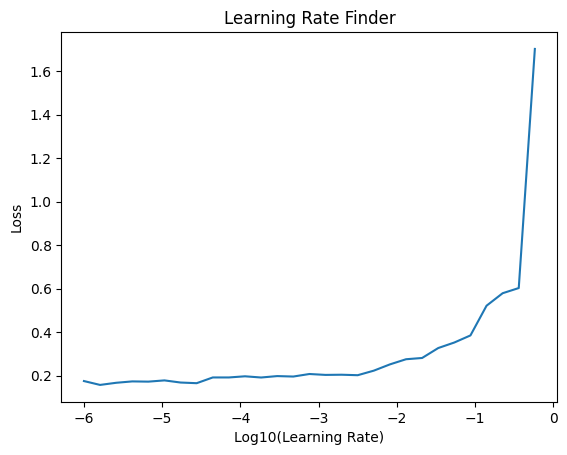

In [ ]:
def find_learning_rate(model, train_loader, optimizer, criterion, device, init_value=1e-6, final_value=10, beta=0.98):
    """
    Encuentra el learning rate óptimo explorando un rango amplio de valores.
    """
    # Configuración inicial
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1 / num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    model.train()  # Configurar en modo entrenamiento

    for batch in train_loader:
        batch_num += 1

        # Obtener los datos
        images = batch['image'].to(device)
        metadata = batch['metadata'].to(device)
        targets = batch['target'].to(device).unsqueeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, targets)

        # Actualizar el promedio de la pérdida (suavizado exponencial)
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        # Guardar el learning rate y la pérdida
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        # Verificar si la pérdida explota
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        # Guardar la mejor pérdida
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        # Incrementar el learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses

# ============================
# Configuración del rango de Learning Rate
# ============================

# Crear el optimizador y el criterio de pérdida
optimizer = optim.Adam(hybrid_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()

# Ejecutar la búsqueda de learning rate
log_lrs, losses = find_learning_rate(hybrid_model, train_loader, optimizer, criterion, device)

# ============================
# Visualizar el Learning Rate Óptimo
# ============================

plt.plot(log_lrs, losses)
plt.xlabel("Log10(Learning Rate)")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


In [ ]:
# Crear el optimizador con el learning rate óptimo
optimal_lr = 10**-2  # 0.01
optimizer = optim.Adam(hybrid_model.parameters(), lr=optimal_lr, weight_decay=1e-4)

# Mantener el scheduler para reducir el learning rate durante el entrenamiento
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


**Reentrenar el Modelo a partir del Learning Rate que parece mas optimo donde empieza a disminuir la perdida**


In [ ]:
# ============================
# Entrenamiento del Modelo
# ============================

# Parámetros de entrenamiento
num_epochs = 15
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Entrenar el modelo
    train_loss, train_acc = train_epoch(hybrid_model, device, train_loader, criterion, optimizer)

    # Validar el modelo
    val_loss, val_acc = eval_epoch(hybrid_model, device, val_loader, criterion)

    # Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Actualizar el learning rate con el scheduler
    scheduler.step()

    # Mostrar métricas del epoch actual
    print(f'[INFO]: Época {epoch+1} ---> '
          f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
          f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')


[INFO]: Época 1 ---> Loss_train = 17.1672, Acc_train = 0.6448, Loss_val = 0.6219, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 2.3415, Acc_train = 0.6685, Loss_val = 0.6213, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 1.6357, Acc_train = 0.6803, Loss_val = 0.6602, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.7478, Acc_train = 0.6785, Loss_val = 0.6216, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6314, Acc_train = 0.6803, Loss_val = 0.7301, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6146, Acc_train = 0.6803, Loss_val = 0.5958, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.5858, Acc_train = 0.6803, Loss_val = 0.4720, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.5598, Acc_train = 0.6803, Loss_val = 0.5687, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.5237, Acc_train = 0.6785, Loss_val = 0.4530, Acc_val = 0.68

**Experimentación con diferentes optimizadores**

Probaremos con los optimizadores SGD, Adam, RMSprop y AdamW.

In [ ]:
# ============================
# Función para Entrenar con Diferentes Optimizadores
# ============================

def train_with_optimizer(optimizer_name, model, train_loader, val_loader, device, num_epochs=15):
    """
    Entrena y evalúa el modelo usando un optimizador específico.
    """
    # Definir la función de pérdida
    criterion = nn.BCELoss()

    # Seleccionar el optimizador
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=1e-4)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
    else:
        raise ValueError(f"Optimizador {optimizer_name} no reconocido")

    # Scheduler para ajustar el learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Métricas para guardar el historial
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print(f"\n[INFO]: Entrenando con {optimizer_name}...\n")

    # Entrenamiento por epochs
    for epoch in range(num_epochs):
        # Entrenar el modelo
        train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)

        # Validar el modelo
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # Guardar métricas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Ajustar el learning rate con el scheduler
        scheduler.step()

        # Imprimir métricas del epoch actual
        print(f'[INFO]: Época {epoch+1} ---> '
              f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
              f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')

    # Retornar métricas finales
    return train_losses, val_losses, train_accs, val_accs


Ejecutar la Experimentación

In [ ]:
# Lista de optimizadores a probar
optimizers = ['SGD', 'Adam', 'RMSprop', 'AdamW']

# Resultados de cada optimizador
results = {}

for opt_name in optimizers:
    # Re-inicializar el modelo para cada optimizador
    model = HybridModel(metadata_input_dim=10)  # Ajustar el input_dim según tus metadatos
    model = model.to(device)

    # Entrenar el modelo con el optimizador actual
    train_losses, val_losses, train_accs, val_accs = train_with_optimizer(
        opt_name, model, train_loader, val_loader, device, num_epochs=15
    )

    # Guardar los resultados
    results[opt_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO]: Entrenando con SGD...

[INFO]: Época 1 ---> Loss_train = 0.6429, Acc_train = 0.6821, Loss_val = 0.6178, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6301, Acc_train = 0.6803, Loss_val = 0.6425, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6298, Acc_train = 0.6803, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6284, Acc_train = 0.6803, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6339, Acc_train = 0.6803, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6300, Acc_train = 0.6803, Loss_val = 0.6182, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6275, Acc_train = 0.6803, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6321, Acc_train = 0.6803, Loss_val = 1.4854, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6285, Acc_train = 0.6803

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.7666, Acc_train = 0.6175, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6641, Acc_train = 0.6685, Loss_val = 0.7164, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6544, Acc_train = 0.6840, Loss_val = 0.6561, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6445, Acc_train = 0.6758, Loss_val = 1.5478, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6327, Acc_train = 0.6803, Loss_val = 1.8141, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6005, Acc_train = 0.7086, Loss_val = 0.5878, Acc_val = 0.7021, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.5646, Acc_train = 0.7541, Loss_val = 0.5843, Acc_val = 0.7191, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.5117, Acc_train = 0.7942, Loss_val = 1.5463, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.4871, Acc_train = 0.8060, Loss_val = 0.2746, Acc_val = 0.93

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 62.8834, Acc_train = 0.3479, Loss_val = 69.2116, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 67.8750, Acc_train = 0.3197, Loss_val = 69.2116, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 68.0714, Acc_train = 0.3197, Loss_val = 69.2116, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 68.0714, Acc_train = 0.3197, Loss_val = 69.2116, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 67.1404, Acc_train = 0.3251, Loss_val = 22.7580, Acc_val = 0.3532, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 22.9497, Acc_train = 0.5109, Loss_val = 1.3720, Acc_val = 0.6043, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6567, Acc_train = 0.6730, Loss_val = 0.6504, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6296, Acc_train = 0.6803, Loss_val = 0.6521, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6374, Acc_train = 0.6785, Loss_val = 0.6239, Acc_

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.7299, Acc_train = 0.6512, Loss_val = 0.6224, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6461, Acc_train = 0.6712, Loss_val = 0.6295, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6416, Acc_train = 0.6803, Loss_val = 0.6159, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6397, Acc_train = 0.6803, Loss_val = 0.6139, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.5987, Acc_train = 0.6903, Loss_val = 0.6696, Acc_val = 0.6894, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.5015, Acc_train = 0.7778, Loss_val = 0.4202, Acc_val = 0.7447, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.4765, Acc_train = 0.7969, Loss_val = 0.5134, Acc_val = 0.7787, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.3661, Acc_train = 0.8388, Loss_val = 0.2553, Acc_val = 0.9532, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.3241, Acc_train = 0.8843, Loss_val = 0.3370, Acc_val = 0.931

Visualización de Resultados

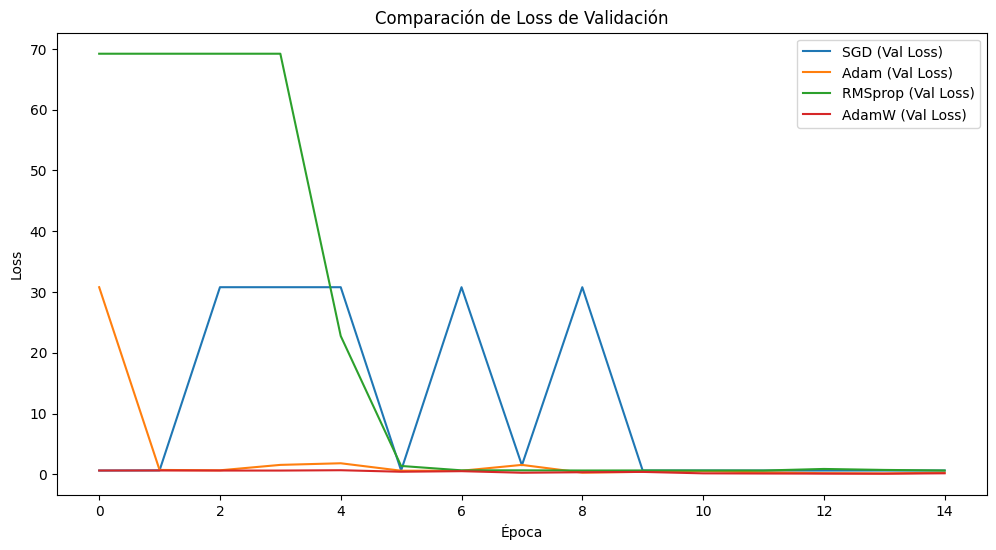

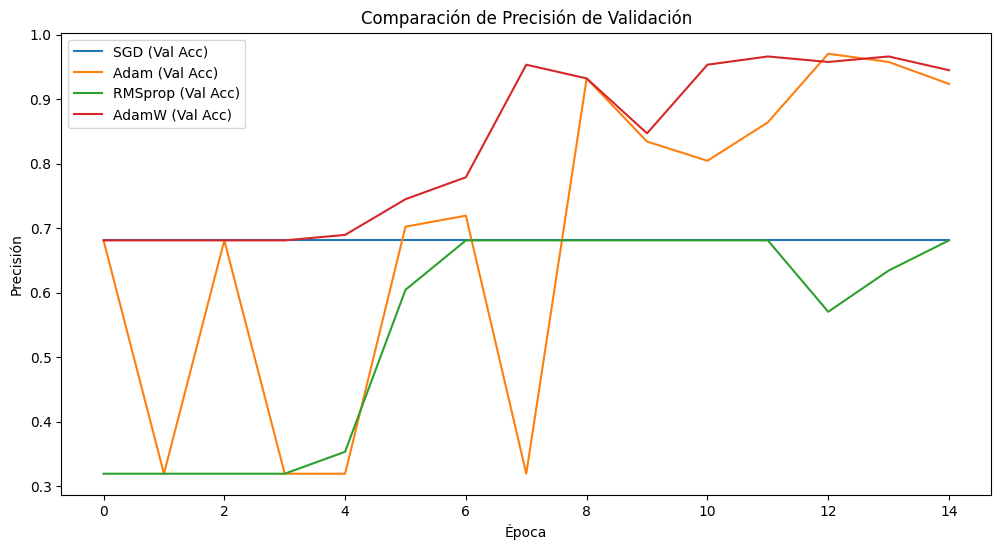

In [ ]:
# Graficar las pérdidas y precisiones de los optimizadores

# Comparar las pérdidas
plt.figure(figsize=(12, 6))
for opt_name in optimizers:
    plt.plot(results[opt_name]['val_losses'], label=f'{opt_name} (Val Loss)')
plt.title('Comparación de Loss de Validación')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Comparar las precisiones
plt.figure(figsize=(12, 6))
for opt_name in optimizers:
    plt.plot(results[opt_name]['val_accs'], label=f'{opt_name} (Val Acc)')
plt.title('Comparación de Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()


(Tras la comparacion vamos a optar por utilizar Adam.

**Actualización del Entrenamiento con Adam**)

**Dejo entre parentesis el comentario anterior** porque despues de añadir algunas capas al modelo y volver a hacer las comparaciones, AdamW parece ser ahora mucho mejor opcion.

**Actualización del Entrenamiento con AdamW**

In [ ]:
# Crear el optimizador AdamW con regularización L2 (Weight Decay)
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.01, weight_decay=1e-4)

# Scheduler para ajustar dinámicamente el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Reentrenar el modelo
num_epochs = 15
train_losses, train_accs, val_losses, val_accs = [], [], [], []

print(f"Entrenando con AdamW como optimizador final...\n")

for epoch in range(num_epochs):
    # Entrenar el modelo
    train_loss, train_acc = train_epoch(hybrid_model, device, train_loader, criterion, optimizer)

    # Validar el modelo
    val_loss, val_acc = eval_epoch(hybrid_model, device, val_loader, criterion)

    # Guardar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Ajustar el learning rate con el scheduler
    scheduler.step()

    # Imprimir métricas del epoch actual
    print(f'[INFO]: Época {epoch+1} ---> '
          f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
          f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')


Entrenando con AdamW como optimizador final...

[INFO]: Época 1 ---> Loss_train = 0.6923, Acc_train = 0.6448, Loss_val = 30.7884, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6455, Acc_train = 0.6740, Loss_val = 0.6159, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6435, Acc_train = 0.6712, Loss_val = 0.6162, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6338, Acc_train = 0.6803, Loss_val = 0.6336, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6209, Acc_train = 0.6803, Loss_val = 0.6128, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6032, Acc_train = 0.6803, Loss_val = 0.5684, Acc_val = 0.6851, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.5145, Acc_train = 0.7741, Loss_val = 0.6130, Acc_val = 0.7234, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.5004, Acc_train = 0.7814, Loss_val = 0.4200, Acc_val = 0.7787, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.4378, Acc_t

**Ajuste de Batch Size y Número de Épocas**

In [ ]:
# ============================
# Función para Entrenar con Diferentes Batch Sizes
# ============================

def train_with_batch_size(batch_size, model, train_data, val_data, device, num_epochs=15):
    """
    Entrena el modelo con un tamaño de batch específico.
    """
    print(f"\n[INFO]: Entrenando con batch_size = {batch_size}...\n")

    # Crear DataLoaders con el batch size actual
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Definir función de pérdida, optimizador y scheduler
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Listas para guardar las métricas
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    # Entrenamiento por epochs
    for epoch in range(num_epochs):
        # Entrenar el modelo
        train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)

        # Validar el modelo
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # Guardar métricas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Ajustar el learning rate con el scheduler
        scheduler.step()

        # Imprimir métricas del epoch actual
        print(f'[INFO]: Época {epoch+1} ---> '
              f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
              f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')

    return train_losses, val_losses, train_accs, val_accs


Ejecutar la Experimentación

In [ ]:
# Tamaños de batch a probar
batch_sizes = [16, 32, 64]

# Resultados para cada batch size
batch_results = {}

for batch_size in batch_sizes:
    # Re-inicializar el modelo para cada experimento
    model = HybridModel(metadata_input_dim=10)
    model = model.to(device)

    # Entrenar con el batch size actual
    train_losses, val_losses, train_accs, val_accs = train_with_batch_size(
        batch_size, model, train_dataset, val_dataset, device, num_epochs=15
    )

    # Guardar resultados
    batch_results[batch_size] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[INFO]: Entrenando con batch_size = 16...

[INFO]: Época 1 ---> Loss_train = 0.7207, Acc_train = 0.6439, Loss_val = 13.4120, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6375, Acc_train = 0.6803, Loss_val = 0.6260, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6477, Acc_train = 0.6794, Loss_val = 0.6658, Acc_val = 0.6085, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6384, Acc_train = 0.6749, Loss_val = 0.7741, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6451, Acc_train = 0.6703, Loss_val = 0.8635, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6330, Acc_train = 0.6776, Loss_val = 0.6824, Acc_val = 0.6681, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6300, Acc_train = 0.6794, Loss_val = 0.6348, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6267, Acc_train = 0.6803, Loss_val = 0.6343, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6298, Acc_train

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.8425, Acc_train = 0.6202, Loss_val = 0.6178, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6516, Acc_train = 0.6712, Loss_val = 0.8992, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6470, Acc_train = 0.6794, Loss_val = 1.3116, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6327, Acc_train = 0.6803, Loss_val = 0.6314, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6350, Acc_train = 0.6803, Loss_val = 0.6559, Acc_val = 0.6851, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6307, Acc_train = 0.6794, Loss_val = 0.6267, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.6282, Acc_train = 0.6794, Loss_val = 0.6223, Acc_val = 0.6809, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.6203, Acc_train = 0.6803, Loss_val = 0.6311, Acc_val = 0.7191, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.6186, Acc_train = 0.6849, Loss_val = 0.6068, Acc_val = 0.680

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Época 1 ---> Loss_train = 0.7577, Acc_train = 0.6230, Loss_val = 7.2938, Acc_val = 0.3191, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6469, Acc_train = 0.6621, Loss_val = 0.6307, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6377, Acc_train = 0.6794, Loss_val = 0.6481, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6421, Acc_train = 0.6803, Loss_val = 0.7167, Acc_val = 0.5234, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6175, Acc_train = 0.6803, Loss_val = 1.3410, Acc_val = 0.3191, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.6222, Acc_train = 0.6803, Loss_val = 0.7844, Acc_val = 0.4511, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.5291, Acc_train = 0.7140, Loss_val = 0.4706, Acc_val = 0.7915, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.5418, Acc_train = 0.7514, Loss_val = 0.5369, Acc_val = 0.7915, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.4804, Acc_train = 0.8142, Loss_val = 0.6563, Acc_val = 0.629

Visualización de Resultados

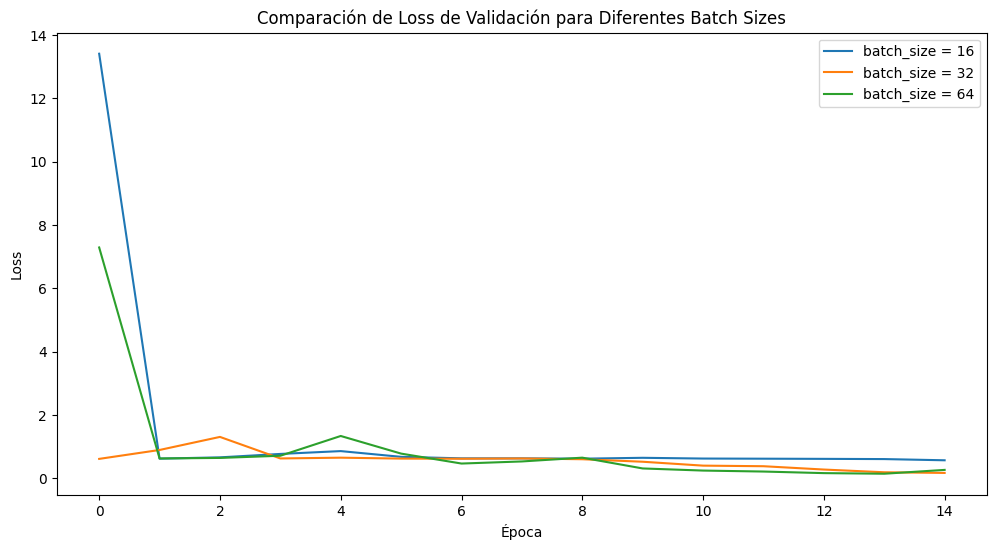

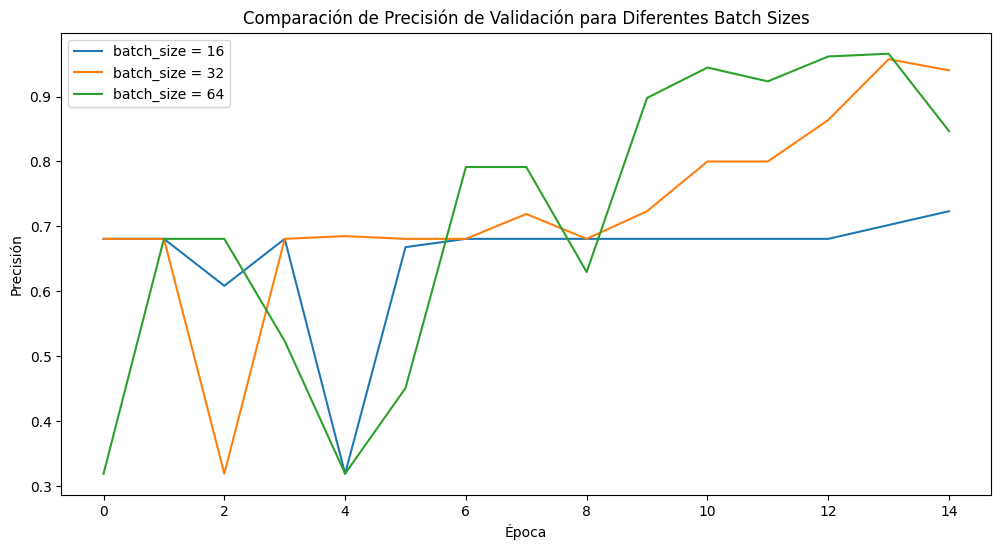

In [ ]:
# Graficar las pérdidas para cada batch size
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(batch_results[batch_size]['val_losses'], label=f'batch_size = {batch_size}')
plt.title('Comparación de Loss de Validación para Diferentes Batch Sizes')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar las precisiones para cada batch size
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(batch_results[batch_size]['val_accs'], label=f'batch_size = {batch_size}')
plt.title('Comparación de Precisión de Validación para Diferentes Batch Sizes')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [ ]:
# ============================
# Configuración Final
# ============================
optimal_batch_size = 32  # Tamaño de lote óptimo
optimal_epochs = 20       # Número de épocas óptimo

# Re-inicializar el modelo para el entrenamiento final
model = HybridModel(metadata_input_dim=10)  # Ajustar input_dim según los metadatos
model = model.to(device)

# Crear los DataLoaders con el batch size óptimo
train_loader = DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=optimal_batch_size, shuffle=False)

# Definir el optimizador, scheduler y función de pérdida
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# ============================
# Entrenamiento Final
# ============================

train_losses, val_losses, train_accs, val_accs = [], [], [], []

print(f"Entrenamiento Final con batch_size = {optimal_batch_size} y epochs = {optimal_epochs}\n")

for epoch in range(optimal_epochs):
    # Entrenar el modelo
    train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)

    # Validar el modelo
    val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

    # Guardar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Ajustar el learning rate con el scheduler
    scheduler.step()

    # Imprimir métricas del epoch actual
    print(f'[INFO]: Época {epoch+1} ---> '
          f'Loss_train = {train_loss:.4f}, Acc_train = {train_acc:.4f}, '
          f'Loss_val = {val_loss:.4f}, Acc_val = {val_acc:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Entrenamiento Final con batch_size = 32 y epochs = 20

[INFO]: Época 1 ---> Loss_train = 0.7491, Acc_train = 0.6521, Loss_val = 0.6195, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 2 ---> Loss_train = 0.6536, Acc_train = 0.6785, Loss_val = 0.6239, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 3 ---> Loss_train = 0.6453, Acc_train = 0.6821, Loss_val = 0.6143, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 4 ---> Loss_train = 0.6387, Acc_train = 0.6694, Loss_val = 0.6158, Acc_val = 0.6809, LR = 0.010000
[INFO]: Época 5 ---> Loss_train = 0.6207, Acc_train = 0.6840, Loss_val = 0.5399, Acc_val = 0.6936, LR = 0.005000
[INFO]: Época 6 ---> Loss_train = 0.5359, Acc_train = 0.7550, Loss_val = 0.4853, Acc_val = 0.8000, LR = 0.005000
[INFO]: Época 7 ---> Loss_train = 0.4755, Acc_train = 0.8069, Loss_val = 0.3099, Acc_val = 0.8638, LR = 0.005000
[INFO]: Época 8 ---> Loss_train = 0.4096, Acc_train = 0.8115, Loss_val = 0.3559, Acc_val = 0.8894, LR = 0.005000
[INFO]: Época 9 ---> Loss_train = 0.3794,

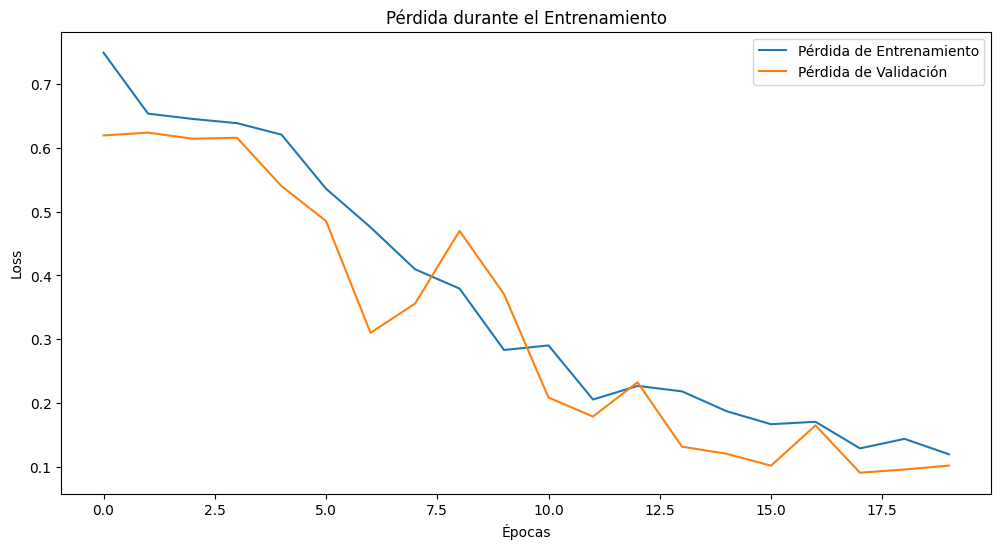

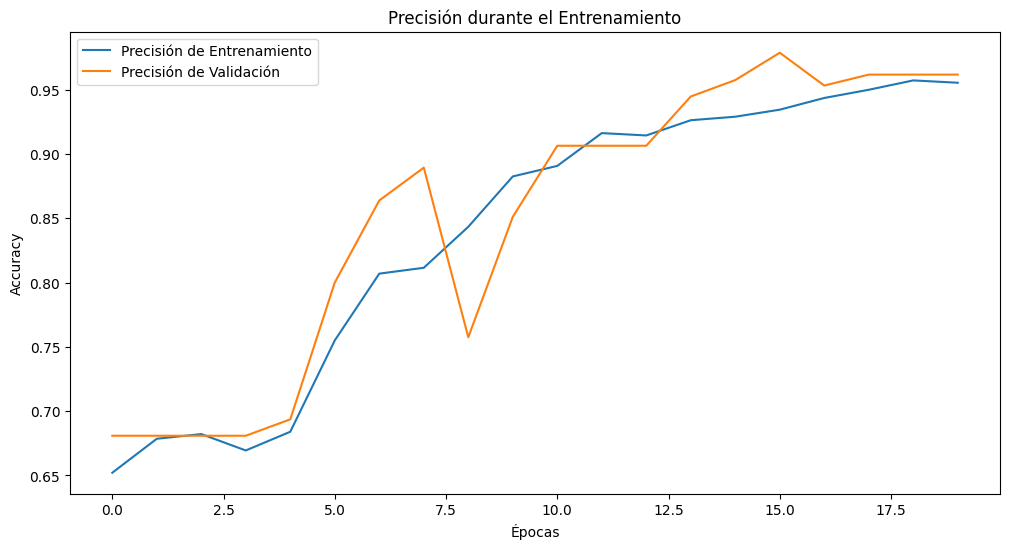

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(train_accs, label='Precisión de Entrenamiento')
plt.plot(val_accs, label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Guardar el Modelo

In [ ]:
# Ruta para guardar el modelo
model_path = "/content/drive/MyDrive/Deep Learning/hybrid_model.pth"

# Guardar el estado del modelo entrenado
torch.save(hybrid_model.state_dict(), model_path)
print(f"Modelo guardado en {model_path}")

# Crear una instancia del modelo con la misma arquitectura
loaded_model = HybridModel(metadata_input_dim=10)  # Asegúrate de usar los mismos parámetros que antes
loaded_model = loaded_model.to(device)

# Cargar los pesos guardados
loaded_model.load_state_dict(torch.load(model_path))
print("Modelo cargado correctamente")

# Configurar el modelo en modo evaluación
loaded_model.eval()



Modelo guardado en /content/drive/MyDrive/Deep Learning/hybrid_model.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modelo cargado correctamente


<ipython-input-19-23dd41d25ad6>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


HybridModel(
  (image_encoder): EfficientNetEncoder(
    (efficientnet): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), s